In [1]:
import cv2
from deepface import DeepFace
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
import json

In [2]:
# Создаем папки для хранения данных
os.makedirs('data/face_database', exist_ok=True)
os.makedirs('data/test_images', exist_ok=True)
os.makedirs('data/results', exist_ok=True)

In [3]:

def check_database():
    """Проверяем базу лиц и выводим информацию"""
    print("Проверка базы лиц...")
    
    people = {}
    for filename in os.listdir('data/face_database'):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            # Предполагаем формат: имя_номер.расширение
            name = filename.split('_')[0]
            if name not in people:
                people[name] = 0
            people[name] += 1
    
    print("Обнаружены следующие люди в базе:")
    for person, count in people.items():
        print(f"  {person}: {count} фотографий")
    
    return people

In [4]:
database_info = check_database()# вызов функции для проверки базы лиц

Проверка базы лиц...
Обнаружены следующие люди в базе:
  al: 5 фотографий
  Max: 5 фотографий


In [5]:
class FaceRecognitionSystem:
    def __init__(self, database_path='data/face_database'):
        self.database_path = database_path
        self.known_faces = {}
        self.load_database()
    
    def load_database(self):
        """Загрузка базы лиц"""
        for filename in os.listdir(self.database_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                name = filename.split('_')[0]
                image_path = os.path.join(self.database_path, filename)
                
                if name not in self.known_faces:
                    self.known_faces[name] = []
                
                self.known_faces[name].append(image_path)
        print(f"Загружено {len(self.known_faces)} людей в базу")

In [6]:
class FaceRecognitionDF(FaceRecognitionSystem):
    """Система на основе DeepFace с верификацией"""
    
    def __init__(self, database_path='data/face_database', verification_threshold=0.6):
        super().__init__(database_path)
        self.verification_threshold = verification_threshold  # Порог для верификации
    
    def recognize_face(self, image):
        """Распознавание и верификация лица на изображении"""
        start_time = time.time()
        
        # Сохраняем временное изображение для DeepFace
        temp_path = 'temp_face.jpg'
        cv2.imwrite(temp_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        results = []
        try:
            # Получаем embedding тестового изображения
            from deepface import DeepFace
            
            test_embedding_obj = DeepFace.represent(
                img_path=temp_path,
                model_name='VGG-Face',
                enforce_detection=False,
                detector_backend='opencv'
            )
            
            if test_embedding_obj:
                test_embedding = test_embedding_obj[0]['embedding']
                test_embedding = np.array(test_embedding)
                
                best_match = None
                best_distance = float('inf')
                best_name = "Unknown"
                verified = False
                
                # Сравниваем с embedding'ами из базы данных
                for name, image_paths in self.known_faces.items():
                    for db_image_path in image_paths:
                        try:
                            db_embedding_obj = DeepFace.represent(
                                img_path=db_image_path,
                                model_name='VGG-Face',
                                enforce_detection=False,
                                detector_backend='opencv'
                            )
                            
                            if db_embedding_obj:
                                db_embedding = db_embedding_obj[0]['embedding']
                                db_embedding = np.array(db_embedding)
                                
                                # Вычисляем евклидово расстояние
                                distance = np.linalg.norm(test_embedding - db_embedding)
                                
                                if distance < best_distance:
                                    best_distance = distance
                                    best_name = name
                                    best_match = db_image_path
                                    
                                    print(f"Проверка {db_image_path}: расстояние {distance:.4f}")
                                    # Верификация: проверяем, проходит ли порог
                                    if distance < self.verification_threshold:
                                        verified = True
                                    else:
                                        verified = False
                                        
                        except Exception as e:
                            print(f"Error processing {db_image_path}: {e}")
                            continue
                
                if best_match is not None:
                    confidence = max(0, 1 - best_distance / 10)  # Нормализуем расстояние в confidence
                    
                    # Получаем локацию лица
                    try:
                        face_analysis = DeepFace.analyze(temp_path, actions=[], enforce_detection=False, silent=True)
                        if len(face_analysis) > 0 and 'region' in face_analysis[0]:
                            region = face_analysis[0]['region']
                            face_location = (
                                region['y'],
                                region['x'] + region['w'],
                                region['y'] + region['h'],
                                region['x']
                            )
                        else:
                            face_location = (0, 0, image.shape[0], image.shape[1])
                    except:
                        face_location = (0, 0, image.shape[0], image.shape[1])
                    
                    # Если верификация не пройдена, помечаем как "Unknown"
                    final_name = best_name if verified else "Unknown"
                    
                    results.append({
                        'name': final_name,
                        'confidence': confidence,
                        'location': face_location,
                        'processing_time': time.time() - start_time,
                        'distance': best_distance,
                        'verified': verified,
                        'original_match': best_name  # Сохраняем исходное совпадение для анализа
                    })
        
        except Exception as e:
            print(f"DeepFace error: {e}")
        
        # Удаляем временный файл
        if os.path.exists(temp_path):
            os.remove(temp_path)
        
        return results

In [7]:
class FaceRecognitionCV(FaceRecognitionSystem):
    """Система на основе OpenCV с верификацией"""
    
    def __init__(self, database_path='data/face_database', verification_threshold=0.7):
        super().__init__(database_path)
        self.verification_threshold = verification_threshold
        self.face_templates = {}
        self.load_face_templates()
    
    def load_face_templates(self):
        """Загрузка шаблонов лиц для сравнения"""
        print("Загрузка шаблонов лиц для OpenCV...")
        
        for name, image_paths in self.known_faces.items():
            self.face_templates[name] = []
            
            for path in image_paths:
                try:
                    image = cv2.imread(path)
                    if image is None:
                        print(f"Не удалось загрузить: {path}")
                        continue
                    
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    
                    # Используем детектор лиц OpenCV
                    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                    face_rects = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    
                    if len(face_rects) > 0:
                        for (x, y, w, h) in face_rects:
                            face_roi = gray[y:y+h, x:x+w]
                            # Создаем шаблон лица (гистограмма)
                            template = self.create_face_template(face_roi)
                            self.face_templates[name].append(template)
                            print(f"Шаблон для {name} из {os.path.basename(path)}")
                    else:
                        print(f"Не найдено лиц в: {os.path.basename(path)}")
                        
                except Exception as e:
                    print(f"Ошибка обработки {path}: {e}")
        
        print(f"Загружено шаблонов: {sum(len(templates) for templates in self.face_templates.values())}")
    
    def create_face_template(self, face_image):
        """Создание шаблона лица на основе гистограммы и HOG-признаков"""
        # Нормализуем размер
        face_resized = cv2.resize(face_image, (100, 100))
        
        # Вычисляем гистограмму
        hist = cv2.calcHist([face_resized], [0], None, [64], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        
        # Вычисляем HOG-признаки (упрощенная версия)
        hog_features = self.compute_simple_hog(face_resized)
        
        # Объединяем признаки
        template = np.concatenate([hist, hog_features])
        
        return template
    
    def compute_simple_hog(self, image):
        """Упрощенное вычисление HOG-признаков"""
        # Вычисляем градиенты
        gx = cv2.Sobel(image, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(image, cv2.CV_32F, 0, 1)
        
        # Вычисляем magnitude и angle
        mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
        
        # Упрощенная гистограмма градиентов
        hog = np.zeros(9)
        for i in range(mag.shape[0]):
            for j in range(mag.shape[1]):
                bin_idx = int(angle[i, j] / 40) % 9  # 9 bins по 40 градусов
                hog[bin_idx] += mag[i, j]
        
        # Нормализуем
        hog = hog / (np.linalg.norm(hog) + 1e-6)
        
        return hog
    
    def compare_templates(self, template1, template2):
        """Сравнение двух шаблонов с помощью косинусного сходства"""
        # Косинусное сходство
        similarity = np.dot(template1, template2) / (np.linalg.norm(template1) * np.linalg.norm(template2) + 1e-6)
        return similarity
    
    def recognize_face(self, image):
        """Распознавание и верификация лица на изображении"""
        start_time = time.time()
        
        try:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            face_rects = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            
            results = []
            for (x, y, w, h) in face_rects:
                face_roi = gray[y:y+h, x:x+w]
                test_template = self.create_face_template(face_roi)
                
                best_name = "Unknown"
                best_similarity = 0
                verified = False
                
                # Сравниваем со всеми шаблонами в базе
                for name, templates in self.face_templates.items():
                    for template in templates:
                        similarity = self.compare_templates(test_template, template)
                        if similarity > best_similarity:
                            best_similarity = similarity
                            best_name = name
                
                # Верификация: проверяем порог сходства
                if best_similarity > self.verification_threshold:
                    verified = True
                    final_name = best_name
                else:
                    verified = False
                    final_name = "Unknown"
                
                face_location = (y, x + w, y + h, x)
                
                results.append({
                    'name': final_name,
                    'confidence': best_similarity,
                    'location': face_location,
                    'processing_time': time.time() - start_time,
                    'similarity': best_similarity,
                    'verified': verified,
                    'original_match': best_name  # Сохраняем исходное совпадение для анализа
                })
            
            return results
        except Exception as e:
            print(f"Ошибка в OpenCV: {e}")
            return []

In [8]:
print("Инициализация систем распознавания...")

systems = {
    'DeepFace': FaceRecognitionDF(verification_threshold=1.0),
    'OpenCV_LBPH': FaceRecognitionCV(verification_threshold=1.0)
}

print("Системы готовы к работе!")

Инициализация систем распознавания...
Загружено 2 людей в базу
Загружено 2 людей в базу
Загрузка шаблонов лиц для OpenCV...
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_1.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_2.jpg
Шаблон для al из al_3.jpg
Шаблон для al из al_3.jpg
Шаблон для al из al_3.jpg
Шаблон для al из al_4.jpg
Шаблон для al из al_4.jpg
Шаблон для al из al_5.jpg
Шаблон для al из al_5.jpg
Шаблон для Max из 

In [9]:
def save_image_with_bbox(image, detections, system_name, original_filename):
    """Сохраняет изображение с bounding boxes и метками"""
    # Создаем копию изображения для рисования
    result_image = image.copy()
    
    for i, detection in enumerate(detections):
        name = detection['name']
        confidence = detection['confidence']
        location = detection['location']
        verified = detection.get('verified', False)
        
        # Извлекаем координаты
        top, right, bottom, left = location
        
        # Цвет bounding box в зависимости от верификации
        color = (0, 255, 0) if verified else (0, 0, 255)  # Зеленый если верифицирован, красный если нет
        thickness = 2
        
        # Рисуем bounding box
        cv2.rectangle(result_image, (left, top), (right, bottom), color, thickness)
        
        # Создаем текст для метки
        status = "VERIFIED" if verified else "UNKNOWN"
        label = f"{name} ({confidence:.2f}) - {status}"
        
        # Размер текста
        font_scale = 0.6
        font_thickness = 2
        
        # Получаем размеры текста
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        
        # Рисуем подложку для текста
        cv2.rectangle(result_image, 
                     (left, top - text_height - 10), 
                     (left + text_width, top), 
                     color, 
                     -1)  # Заливаем
        
        # Рисуем текст
        cv2.putText(result_image, label, 
                   (left, top - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 
                   font_scale, 
                   (255, 255, 255),  # Белый текст
                   font_thickness)
    
    # Создаем путь для сохранения
    if detections:
        # Если есть распознанные лица, используем имя первого распознанного
        first_person = detections[0]['name']
        save_dir = f"data/results/{system_name}/{first_person}"
    else:
        # Если лиц не найдено
        save_dir = f"data/results/{system_name}/unk"
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Сохраняем изображение
    filename = os.path.splitext(original_filename)[0] + '_result.jpg'
    save_path = os.path.join(save_dir, filename)
    
    # Конвертируем обратно в BGR для сохранения
    result_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, result_image_bgr)
    
    return save_path

def test_on_single_image(image_path):
    """Тестирование на конкретном изображении"""
    if not os.path.exists(image_path):
        print(f"Изображение {image_path} не найдено!")
        return
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return
        
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_filename = os.path.basename(image_path)
    
    print(f"\nТестирование на {original_filename}:")
    print("Размер изображения:", image.shape)
    
    for name, system in systems.items():
        start_time = time.time()
        results = system.recognize_face(rgb_image)
        total_time = time.time() - start_time
        
        print(f"\n{name}:")
        print(f"  Время обработки: {total_time:.3f} сек")
        print(f"  Найдено лиц: {len(results)}")
        
        # Сохраняем изображение с bounding boxes
        if results:
            save_path = save_image_with_bbox(rgb_image, results, name, original_filename)
            print(f"  Результат сохранен: {save_path}")
        
        for i, result in enumerate(results):
            verification_status = "✓ ВЕРИФИЦИРОВАН" if result.get('verified', False) else "✗ НЕ ВЕРИФИЦИРОВАН"
            print(f"    Лицо {i+1}: {result['name']} (confidence: {result['confidence']:.3f}) [{verification_status}]")
            if not result.get('verified', False) and 'original_match' in result:
                print(f"          Наибольшее сходство с: {result['original_match']} (similarity: {result.get('similarity', result.get('distance', 0)):.3f})")
    
    print("-" * 50)

Проверка тестовых изображений...

ОСНОВНОЕ ТЕСТИРОВАНИЕ
Тестирование на 1.jpg...
Проверка data/face_database\al_1.jpg: расстояние 1.3705
Проверка data/face_database\al_3.jpg: расстояние 1.3261
Проверка data/face_database\Max_1.jpg: расстояние 1.2140
Проверка data/face_database\Max_2.jpg: расстояние 1.1461
Проверка data/face_database\Max_3.jpg: расстояние 1.0808
Проверка data/face_database\Max_4.jpg: расстояние 0.9414
  DeepFace: 1 лиц, время: 24.58 сек -> data/results/DeepFace/Max\1_result.jpg
  OpenCV_LBPH: 1 лиц, время: 0.05 сек -> data/results/OpenCV_LBPH/Unknown\1_result.jpg
Тестирование на 3.jpg...
Проверка data/face_database\al_1.jpg: расстояние 1.3518
Проверка data/face_database\al_2.jpg: расстояние 1.0996
Проверка data/face_database\al_3.jpg: расстояние 0.8577
  DeepFace: 1 лиц, время: 19.93 сек -> data/results/DeepFace/al\3_result.jpg
  OpenCV_LBPH: 0 лиц, время: 0.03 сек -> data/results/OpenCV_LBPH/unk\3_result.jpg
Тестирование на 4.jpg...
Проверка data/face_database\al_1.jpg

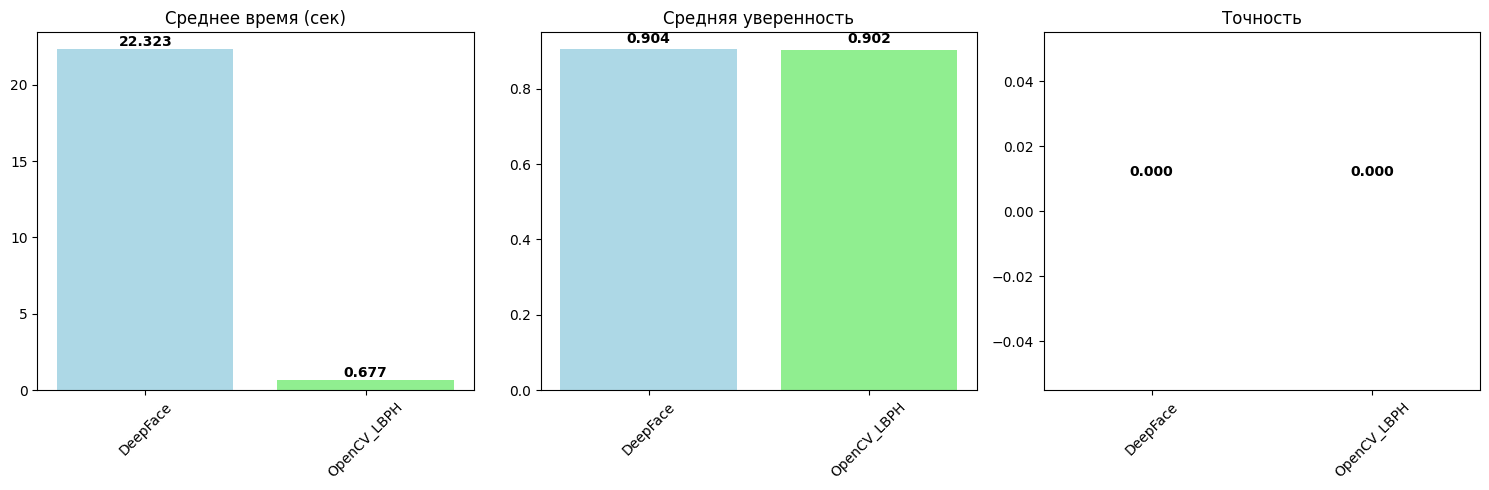


СВОДКА ПО СОХРАНЕННЫМ РЕЗУЛЬТАТАМ

DeepFace:
  al: 4 изображений
  Unknown: 4 изображений
  Max: 1 изображений
  Всего: 9 изображений

OpenCV_LBPH:
  Unknown: 7 изображений
  unk: 2 изображений
  Всего: 9 изображений

Все результаты сохранены в папке 'data/results/'


In [10]:
print("Проверка тестовых изображений...")
test_files = [f for f in os.listdir('data/test_images') if f.endswith(('.jpg', '.png', '.jpeg'))]

def save_image_with_bbox(image, detections, system_name, original_filename):
    """Сохраняет изображение с bounding boxes и метками"""
    # Создаем копию изображения для рисования
    result_image = image.copy()
    
    for i, detection in enumerate(detections):
        name = detection['name']
        confidence = detection['confidence']
        location = detection['location']
        verified = detection.get('verified', False)
        
        # Извлекаем координаты
        top, right, bottom, left = location
        
        # Цвет bounding box в зависимости от верификации
        color = (0, 255, 0) if verified else (0, 0, 255)  # Зеленый если верифицирован, красный если нет
        thickness = 2
        
        # Рисуем bounding box
        cv2.rectangle(result_image, (left, top), (right, bottom), color, thickness)
        
        # Создаем текст для метки
        status = "VERIFIED" if verified else "UNKNOWN"
        label = f"{name} ({confidence:.2f}) - {status}"
        
        # Размер текста
        font_scale = 0.6
        font_thickness = 2
        
        # Получаем размеры текста
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        
        # Рисуем подложку для текста
        cv2.rectangle(result_image, 
                     (left, top - text_height - 10), 
                     (left + text_width, top), 
                     color, 
                     -1)  # Заливаем
        
        # Рисуем текст
        cv2.putText(result_image, label, 
                   (left, top - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 
                   font_scale, 
                   (255, 255, 255),  # Белый текст
                   font_thickness)
    
    # Создаем путь для сохранения
    if detections:
        # Если есть распознанные лица, используем имя первого распознанного
        first_person = detections[0]['name']
        save_dir = f"data/results/{system_name}/{first_person}"
    else:
        # Если лиц не найдено
        save_dir = f"data/results/{system_name}/unk"
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Сохраняем изображение
    filename = os.path.splitext(original_filename)[0] + '_result.jpg'
    save_path = os.path.join(save_dir, filename)
    
    # Конвертируем обратно в BGR для сохранения
    result_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, result_image_bgr)
    
    return save_path

def test_on_single_image(image_path):
    """Тестирование на конкретном изображении"""
    if not os.path.exists(image_path):
        print(f"Изображение {image_path} не найдено!")
        return
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return
        
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_filename = os.path.basename(image_path)
    
    print(f"\nТестирование на {original_filename}:")
    print("Размер изображения:", image.shape)
    
    for name, system in systems.items():
        start_time = time.time()
        results = system.recognize_face(rgb_image)
        total_time = time.time() - start_time
        
        print(f"\n{name}:")
        print(f"  Время обработки: {total_time:.3f} сек")
        print(f"  Найдено лиц: {len(results)}")
        
        # Сохраняем изображение с bounding boxes
        if results:
            save_path = save_image_with_bbox(rgb_image, results, name, original_filename)
            print(f"  Результат сохранен: {save_path}")
        
        for i, result in enumerate(results):
            verification_status = "✓ ВЕРИФИЦИРОВАН" if result.get('verified', False) else "✗ НЕ ВЕРИФИЦИРОВАН"
            print(f"    Лицо {i+1}: {result['name']} (confidence: {result['confidence']:.3f}) [{verification_status}]")
            if not result.get('verified', False) and 'original_match' in result:
                print(f"          Наибольшее сходство с: {result['original_match']} (similarity: {result.get('similarity', result.get('distance', 0)):.3f})")
    
    print("-" * 50)

def test_systems_on_images(systems, test_images_path='data/test_images'):
    """Тестирование всех систем на наборе изображений с сохранением результатов"""
    
    results = {name: [] for name in systems.keys()}
    
    test_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not test_files:
        print("Нет тестовых изображений!")
        return None
    
    for test_file in test_files:
        test_path = os.path.join(test_images_path, test_file)
        print(f"Тестирование на {test_file}...")
        
        # Загружаем изображение
        image = cv2.imread(test_path)
        if image is None:
            continue
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        for system_name, system in systems.items():
            start_time = time.time()
            frame_results = system.recognize_face(rgb_image)
            total_time = time.time() - start_time
            
            # Сохраняем изображение с bounding boxes для каждого метода
            if frame_results:
                save_path = save_image_with_bbox(rgb_image, frame_results, system_name, test_file)
                print(f"  {system_name}: {len(frame_results)} лиц, время: {total_time:.2f} сек -> {save_path}")
            else:
                save_path = save_image_with_bbox(rgb_image, [], system_name, test_file)
                print(f"  {system_name}: 0 лиц, время: {total_time:.2f} сек -> {save_path}")
            
            results[system_name].append({
                'image': test_file,
                'detections': frame_results,
                'num_faces_detected': len(frame_results),
                'total_processing_time': total_time,
                'saved_path': save_path
            })

    return results

def analyze_results(results):
    """Анализ результатов тестирования"""
    analysis = {}
    
    for system_name, system_results in results.items():
        total_images = len(system_results)
        total_faces_detected = sum([r['num_faces_detected'] for r in system_results])
        total_processing_time = sum([r['total_processing_time'] for r in system_results])
        
        # Собираем confidence scores
        confidence_scores = []
        recognized_names = []
        
        for image_result in system_results:
            for detection in image_result['detections']:
                confidence_scores.append(detection.get('confidence', 0))
                recognized_names.append(detection.get('name', 'Unknown'))
        
        # Анализ правильности распознавания (если есть ожидаемые имена)
        correct_recognition = 0
        total_recognition = 0
        
        for image_result in system_results:
            image_name = image_result['image'].lower()
            for detection in image_result['detections']:
                detected_name = detection.get('name', '').lower()
                total_recognition += 1
                # Простая эвристика: если имя в названии файла совпадает с распознанным
                if detected_name in image_name or image_name.startswith(detected_name):
                    correct_recognition += 1
        
        accuracy = correct_recognition / total_recognition if total_recognition > 0 else 0
        
        analysis[system_name] = {
            'total_images': total_images,
            'total_faces_detected': total_faces_detected,
            'average_faces_per_image': total_faces_detected / total_images if total_images > 0 else 0,
            'average_processing_time_per_image': total_processing_time / total_images if total_images > 0 else 0,
            'average_confidence': np.mean(confidence_scores) if confidence_scores else 0,
            'success_rate': total_faces_detected / total_images if total_images > 0 else 0,
            'accuracy': accuracy
        }
    
    return analysis

def visualize_comparison(analysis):
    """Визуализация сравнения систем"""
    systems = list(analysis.keys())
    metrics = ['average_processing_time_per_image', 'average_confidence', 'accuracy']
    metric_names = ['Среднее время (сек)', 'Средняя уверенность', 'Точность']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    colors = ['lightblue', 'lightgreen']
    
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        values = [analysis[system][metric] for system in systems]
        bars = axes[i].bar(systems, values, color=colors[:len(systems)])
        axes[i].set_title(metric_name)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Добавляем значения на столбцы
        for bar, v in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('data/results/comparison_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
# Добавим функцию для просмотра результатов
def show_results_summary():
    """Показывает сводку по сохраненным результатам"""
    print("\n" + "="*60)
    print("СВОДКА ПО СОХРАНЕННЫМ РЕЗУЛЬТАТАМ")
    print("="*60)
    
    results_dir = 'data/results'
    if not os.path.exists(results_dir):
        print("Папка с результатами не найдена!")
        return
    
    for system_name in systems.keys():
        system_dir = os.path.join(results_dir, system_name)
        if os.path.exists(system_dir):
            print(f"\n{system_name}:")
            
            # Считаем результаты по категориям
            categories = {}
            total_images = 0
            
            for category in os.listdir(system_dir):
                category_dir = os.path.join(system_dir, category)
                if os.path.isdir(category_dir):
                    image_count = len([f for f in os.listdir(category_dir) if f.endswith('_result.jpg')])
                    categories[category] = image_count
                    total_images += image_count
            
            # Сортируем по количеству изображений
            for category, count in sorted(categories.items(), key=lambda x: x[1], reverse=True):
                print(f"  {category}: {count} изображений")
            
            print(f"  Всего: {total_images} изображений")

# В конце основного тестирования добавим вызов сводки
if test_files:
    print("\n" + "="*50)
    print("ОСНОВНОЕ ТЕСТИРОВАНИЕ")
    print("="*50)
    
    results = test_systems_on_images(systems)
    
    if results:
        analysis = analyze_results(results)
        
        print("\nРЕЗУЛЬТАТЫ СРАВНЕНИЯ:")
        for system_name, stats in analysis.items():
            print(f"\n{system_name}:")
            print(f"  Обработано изображений: {stats['total_images']}")
            print(f"  Всего обнаружено лиц: {stats['total_faces_detected']}")
            print(f"  Успешность обнаружения: {stats['success_rate']:.3f}")
            print(f"  Точность распознавания: {stats['accuracy']:.3f}")
            print(f"  Среднее время обработки: {stats['average_processing_time_per_image']:.3f} сек")
            print(f"  Средняя уверенность: {stats['average_confidence']:.3f}")
        
        # Визуализация
        visualize_comparison(analysis)
        
        # Сохранение результатов
        with open('data/results/comparison_results.json', 'w') as f:
            json.dump(analysis, f, indent=2)
        
        # Показываем сводку по сохраненным изображениям
        show_results_summary()
        
        print("\nВсе результаты сохранены в папке 'data/results/'")
